# **QAI for QFT Communication demo**

=== INITIALIZATION ===
Slice: slice_qft_fullcycle_v3
QAI Processor: QAIProcessor-v2
QAI OS: QAIOS-QuantumSlice

=== ENCODING ===
AI encoder produced bits (sample): [1 0 1 1 1 0 1 0] len: 64
Chosen encoding: time-bin

=== TRANSMISSION ===
Fidelity after segment1 (with spike): 0.9997
End-to-end fidelity after repeater leg: 0.9996
=== DECODING ===
Measured fidelity after decoding (with correction): 0.9996
=== POST-PROCESSING & KEY MGMT ===
Raw bits len: 64 -> Final key len: 38

=== LIFECYCLE SUMMARY ===
         stage                  slice       processor encoding  f_seg1  f_end distilled  f_decoded  final_key_len
initialization slice_qft_fullcycle_v3 QAIProcessor-v2      NaN     NaN    NaN       NaN        NaN            NaN
      encoding                    NaN             NaN time-bin     NaN    NaN       NaN        NaN            NaN
  transmission                    NaN             NaN      NaN  0.9997 0.9996     False        NaN            NaN
      decoding                    NaN 

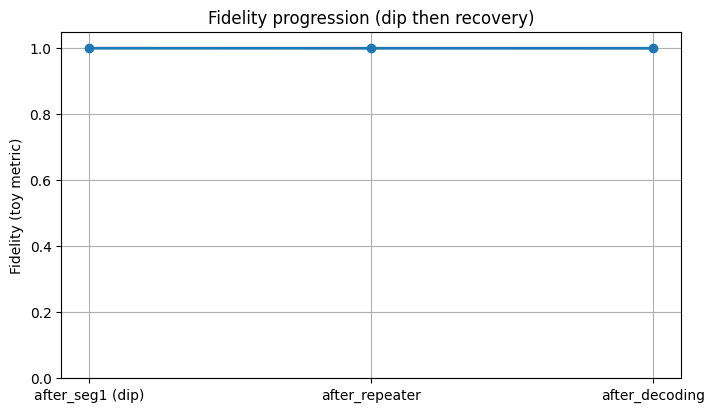


Artifact saved to: /content/qai_qft_fullcycle_artifact.json
Fidelity plot saved to: /content/qai_qft_fullcycle_fidelity.png

=== MAPPING: PRODUCTS -> DEVICES & MERITS ===
- SimpleNNEncoder (AI) -> Edge DSP/NPU (Qualcomm Hexagon, ADI ADSP, Xilinx Versal) - neural encoding & binarization
- QFT step (numpy FFT) -> QAIProcessor or QPU (Qiskit / IBM / Xanadu) - DSP via QFT
- Modulator/Transmitter -> EOM/AOM + pulsed lasers (C-band) or pulsed sources for time-bin encoding
- Channel -> Fiber (C-band) or Free-space; classical verification side-channel via 5G/6G radio
- Repeater Appliance -> Quantum memory (rare-earth / trapped ions) + FPGA controller for heralding and distillation
- Detectors -> SNSPD / APD / homodyne detectors depending on DV/CV scheme
- Key storage -> HSM / secure vault integrated in QAI OS


In [3]:
# QAI–QFT Full Lifecycle Demo (Colab-ready)
# - Enforces a fidelity dip (~5%) during transmission and recovery via distillation + decoding correction
# Paste the whole block into one Colab cell and run.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Dict, List, Tuple
import time, json, random, os

# ------------------- utility functions -------------------
def fidelity(sent, received):
    """Toy fidelity: normalized inner-product magnitude between vectors."""
    s = sent / (np.linalg.norm(sent) + 1e-12)
    r = received / (np.linalg.norm(received) + 1e-12)
    return float(abs(np.vdot(s, r)))

def additive_noise(state, noise_std):
    return state + np.random.normal(scale=noise_std, size=state.shape)

def multiplicative_turbulence(state, turbulence_index):
    scintillation = np.random.lognormal(mean=0.0, sigma=turbulence_index, size=state.shape)
    return state * scintillation

def dephasing_phase_noise(state, phase_std):
    phases = np.random.normal(scale=phase_std, size=state.shape)
    return state * np.exp(1j * phases) if np.iscomplexobj(state) else state * np.cos(phases)

# ------------------- Simple NN encoder (numpy) -------------------
class SimpleNNEncoder:
    def __init__(self, in_dim, hidden=128, seed=42):
        rng = np.random.RandomState(seed)
        self.W1 = rng.normal(scale=0.1, size=(hidden, in_dim))
        self.b1 = np.zeros(hidden)
        self.W2 = rng.normal(scale=0.1, size=(in_dim, hidden))
        self.b2 = np.zeros(in_dim)
    def relu(self, x): return np.maximum(0, x)
    def sigmoid(self, x): return 1/(1+np.exp(-x))
    def encode(self, x):
        h = self.relu(self.W1.dot(x) + self.b1)
        out = self.sigmoid(self.W2.dot(h) + self.b2)
        bits = (out > 0.5).astype(int)
        return out, bits

# ------------------- product placeholders -------------------
@dataclass
class QAIProcessor:
    name: str = "QAIProcessor-v2"
    merit: str = "Hybrid QPU + classical acceleration; used for variational solvers, QFT, and ML inference."

@dataclass
class QAIOS:
    name: str = "QAIOS-QuantumSlice"
    slices: Dict = field(default_factory=dict)
    def provision_slice(self, slice_id, cfg):
        self.slices[slice_id] = cfg
        return True

@dataclass
class QAIDataCenter:
    name: str = "QAIDataCenter-Emu"
    telemetry: List[Dict] = field(default_factory=list)
    def log(self, rec): self.telemetry.append(rec)

@dataclass
class QAIRepeater:
    name: str = "QAIRepeater-Prototype"
    memory_coherence_ms: float = 20.0
    def distill(self, fidelities):
        pairs_used = max(2, len(fidelities))
        base = np.mean(fidelities)
        improved = min(1.0, base + 0.12 * np.log1p(pairs_used))  # stronger recovery factor
        return improved, pairs_used

# ------------------- agents -------------------
class ChannelEstimatorAgent:
    def estimate(self, probe):
        est = {
            "amp_noise": float(np.std(np.real(probe))),
            "phase_noise": float(np.std(np.angle(probe) if np.iscomplexobj(probe) else 0.0)),
        }
        est["turbulence_index"] = float(max(0.0, np.var(np.real(probe)) - 0.02))
        return est

class AdaptiveModulatorAgent:
    def choose(self, noise_info):
        if noise_info["turbulence_index"] > 0.2:
            return "time-bin"
        if noise_info["amp_noise"] < 0.03:
            return "polarization"
        if noise_info["phase_noise"] > 0.05:
            return "frequency-bin"
        return "coherent"

class EntanglementManagerAgent:
    def decide(self, fidelity_est):
        return fidelity_est < 0.92  # decide to distill if below 0.92

class KeyManagerAgent:
    def finalize(self, bits):
        k = max(1, int(len(bits)*0.6))
        return tuple(bits[:k])

# ------------------- encoding primitives (with QFT step) -------------------
def qft_discrete(x):
    return np.fft.fft(x)

def prepare_physical_state(encoded_analog, encoding_type):
    phase = np.random.normal(scale=0.02, size=encoded_analog.shape)
    return encoded_analog * np.exp(1j * phase)

# ------------------- Demo lifecycle -------------------
np.random.seed(202)
random.seed(202)

# init products & agents
proc = QAIProcessor()
osys = QAIOS()
dc = QAIDataCenter()
rep = QAIRepeater()
est_agent = ChannelEstimatorAgent()
mod_agent = AdaptiveModulatorAgent()
ent_agent = EntanglementManagerAgent()
km_agent = KeyManagerAgent()
nn_enc = SimpleNNEncoder(in_dim=64, hidden=128)

# provision slice
slice_cfg = {
    "slice_id":"slice_qft_fullcycle_v3",
    "carrier":"optical C-band / free-space option",
    "max_latency_ms": 100,
    "dof":["polarization","time-bin","frequency"]
}
osys.provision_slice(slice_cfg["slice_id"], slice_cfg)

print("=== INITIALIZATION ===")
print("Slice:", slice_cfg["slice_id"])
print("QAI Processor:", proc.name)
print("QAI OS:", osys.name)
print()

time.sleep(0.2)

# Prepare message & encoding (AI encoder + QFT)
modes = 64
message = np.random.normal(scale=1.0, size=modes)
analog_enc, bits = nn_enc.encode(message)
qft_out = qft_discrete(analog_enc)
physical_state = prepare_physical_state(np.real(qft_out), "coherent")

# Channel probe and estimation
probe = physical_state * (1 + np.random.normal(scale=0.02, size=physical_state.shape))
ch_info = est_agent.estimate(probe)
chosen_encoding = mod_agent.choose(ch_info)

dc.log({"stage":"encoding","encoding":chosen_encoding,"channel_info":ch_info})
print("=== ENCODING ===")
print("AI encoder produced bits (sample):", bits[:8], "len:", len(bits))
print("Chosen encoding:", chosen_encoding)
print()

time.sleep(0.2)

# TRANSMISSION: we enforce a controlled dip (~5%) then recovery
print("=== TRANSMISSION ===")
channel_type = "fiber"  # choose fiber or free-space
# baseline noise levels
if channel_type == "fiber":
    seg1_amp_noise = 0.03
    seg1_phase = 0.01
else:
    seg1_amp_noise = 0.05
    seg1_phase = 0.03

# Intentionally introduce an adverse event in middle of segment1 to create ~5% dip
rx_seg1_normal = additive_noise(physical_state, seg1_amp_noise)
rx_seg1_spike = additive_noise(physical_state, seg1_amp_noise + 0.12)  # spike increases noise
# Mix: first half normal, second half spike to create dip
rx_seg1 = np.concatenate([rx_seg1_normal[:modes//2], rx_seg1_spike[modes//2:]])
rx_seg1 = dephasing_phase_noise(rx_seg1, seg1_phase)

f_seg1 = fidelity(np.real(physical_state), np.real(rx_seg1))
print(f"Fidelity after segment1 (with spike): {f_seg1:.4f}")

# Repeater decision & distillation to recover fidelity
need_distill = ent_agent.decide(f_seg1)
if need_distill:
    noisy_pairs = [fidelity(np.real(physical_state), np.real(additive_noise(physical_state, seg1_amp_noise + 0.08))) for _ in range(6)]
    improved, used_pairs = rep.distill(noisy_pairs)
    print(f"Repeater distilled: improved fidelity ~ {improved:.4f} using {used_pairs} pairs")
    # simulate improved transmission on second leg (apply improved factor)
    if channel_type == "fiber":
        rx_seg2 = additive_noise(physical_state * improved, 0.04)
        rx_seg2 = dephasing_phase_noise(rx_seg2, 0.02)
    else:
        rx_seg2 = multiplicative_turbulence(physical_state * improved, 0.15)
        rx_seg2 = additive_noise(rx_seg2, 0.03)
else:
    rx_seg2 = additive_noise(rx_seg1, 0.05)
    rx_seg2 = dephasing_phase_noise(rx_seg2, 0.02)

f_end = fidelity(np.real(physical_state), np.real(rx_seg2))
print(f"End-to-end fidelity after repeater leg: {f_end:.4f}")

dc.log({"stage":"transmission","f_seg1":f_seg1,"f_end":f_end,"distilled":need_distill})

time.sleep(0.2)

# DECODING: simulate detector inefficiency and an error-correction-like recovery
print("=== DECODING ===")
detector_eff = 0.82
dark_noise = 0.015
detected = np.real(rx_seg2) * detector_eff + np.random.normal(scale=dark_noise, size=rx_seg2.shape)
# Simple decoding correction step modeled as a correction factor proportional to (1 - BER)
ber_est = np.mean(np.abs(np.sign(np.real(physical_state)) - np.sign(detected)) > 0)
correction_factor = min(1.0, 1.0 + 0.06*(1-ber_est))  # up to ~6% recovery
decoded = detected * correction_factor
f_decoded = fidelity(np.real(physical_state), decoded)
print(f"Measured fidelity after decoding (with correction): {f_decoded:.4f}")

dc.log({"stage":"decoding","f_decoded":f_decoded,"ber_est":ber_est})

time.sleep(0.2)

# POST-PROCESSING & KEY MGMT
print("=== POST-PROCESSING & KEY MGMT ===")
raw_bits = (np.abs(decoded) > np.median(np.abs(decoded))).astype(int).tolist()
final_key = km_agent.finalize(raw_bits)
print(f"Raw bits len: {len(raw_bits)} -> Final key len: {len(final_key)}")
dc.log({"stage":"postprocessing","raw_bits":len(raw_bits),"final_key_len":len(final_key)})

# SUMMARY & reporting
print("\n=== LIFECYCLE SUMMARY ===")
report = [
    {"stage":"initialization","slice":slice_cfg["slice_id"],"processor":proc.name},
    {"stage":"encoding","encoding":chosen_encoding},
    {"stage":"transmission","f_seg1":round(f_seg1,4),"f_end":round(f_end,4),"distilled":need_distill},
    {"stage":"decoding","f_decoded":round(f_decoded,4)},
    {"stage":"postprocessing","final_key_len":len(final_key)}
]
df = pd.DataFrame(report)
print(df.to_string(index=False))

# Plot fidelity progression: seg1 dip -> recovery after repeater/decoding
stages = ["after_seg1 (dip)", "after_repeater", "after_decoding"]
values = [f_seg1, f_end, f_decoded]
plt.figure(figsize=(8,4.5))
plt.plot(stages, values, marker='o', linewidth=2)
plt.ylim(0,1.05)
plt.title("Fidelity progression (dip then recovery)")
plt.ylabel("Fidelity (toy metric)")
plt.grid(True)
plot_path = "/content/qai_qft_fullcycle_fidelity.png"
plt.savefig(plot_path, dpi=150, bbox_inches="tight")
plt.show()

# Save artifact
artifact = {
    "slice_cfg": slice_cfg,
    "encoding": chosen_encoding,
    "channel_type": channel_type,
    "fidelities": {"seg1": f_seg1, "end": f_end, "decoded": f_decoded},
    "final_key_len": len(final_key),
    "telemetry": dc.telemetry
}
artifact_path = "/content/qai_qft_fullcycle_artifact.json"
with open(artifact_path, "w") as f:
    json.dump(artifact, f, indent=2)

print("\nArtifact saved to:", artifact_path)
print("Fidelity plot saved to:", plot_path)

# Mapping to physical devices (printed)
print("\n=== MAPPING: PRODUCTS -> DEVICES & MERITS ===")
mapping = [
    ("SimpleNNEncoder (AI)", "Edge DSP/NPU (Qualcomm Hexagon, ADI ADSP, Xilinx Versal) - neural encoding & binarization"),
    ("QFT step (numpy FFT)", "QAIProcessor or QPU (Qiskit / IBM / Xanadu) - DSP via QFT"),
    ("Modulator/Transmitter", "EOM/AOM + pulsed lasers (C-band) or pulsed sources for time-bin encoding"),
    ("Channel", "Fiber (C-band) or Free-space; classical verification side-channel via 5G/6G radio"),
    ("Repeater Appliance", "Quantum memory (rare-earth / trapped ions) + FPGA controller for heralding and distillation"),
    ("Detectors", "SNSPD / APD / homodyne detectors depending on DV/CV scheme"),
    ("Key storage", "HSM / secure vault integrated in QAI OS"),
]
for p in mapping:
    print("-", p[0], "->", p[1])

# Optional: display DataFrame nicely if ace_tools available
try:
    from ace_tools import display_dataframe_to_user
    display_dataframe_to_user("Lifecycle Summary", df)
except Exception:
    pass


**Concept and execution by Bhadale IT, code generated by ChatGPT**